# Ejemplo de datos con censura

Datos de consumo de gas LP, ¿cuánto Gas LP consumen los hogares en México?, ¿tiene sustitutos?

## 1. Importación de bibliotecas y datos:

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col
from tobit import *

# Omiting WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
GasLP_df = pd.read_stata('Gas_LP.dta')
GasLP_df

,folioviv,foliohog,ageb,est_dis,upm,factor,ubica_geo,entidad,cve_ent,Entidad,...,p_gasnat,lp_gasnat,lp_gasnat_kg,gasto_carb,gasto_lena,gasto_perol,gasto_diesel,gasto_comb,gasto_otroscomb,acc_gasnat
0,0202822602,1,689-3,017,0003860,544.0,020020001,Baja California,2.0,BAJA CALIFORNIA,...,245.769196,5.504393,2.498681,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2802005301,1,302-5,451,0068990,582.0,280220001,Tamaulipas,28.0,TAMAULIPAS,...,224.633987,5.414473,2.408761,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1000893202,1,398-4,140,0028020,295.0,100050001,Durango,10.0,DURANGO,...,304.743591,5.719471,2.713759,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0503695701,1,088-4,061,0013210,317.0,050350001,Coahuila de Zaragoza,5.0,COAHUILA DE ZARAGOZA,...,320.102020,5.768640,2.762928,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0801075702,1,299-9,118,0020230,530.0,080190001,Chihuahua,8.0,CHIHUAHUA,...,250.919601,5.525133,2.519421,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70306,0702164504,1,262-2,094,0018900,1035.0,071010001,Chiapas,7.0,CHIAPAS,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70307,1505068605,1,154-2,226,0037880,2870.0,150330001,MÃ©xico,15.0,MÃXICO,...,144.095200,4.970474,1.964762,0.0,0.0,0.0,0.0,255.0,0.0,1.0
70308,0660119614,1,021-9,093,0018300,23.0,060040015,Colima,6.0,COLIMA,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70309,0704388512,1,003-6,109,0019280,646.0,071020012,Chiapas,7.0,CHIAPAS,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0


* folioviv: Identificador de la vivienda
* foliohog: Identificador del hogar
* ageb: Área geoestadísstica básica
* est_dis: Estrato de diseño muestral
* upm: Unidad primaria de muestreo
* factor: Factor de expansión
* ubica_geo: Ubicación geográfica
* entidad: Entidad
* cve_ent:               
* Entidad: Entidad
* cve_mun     
* nom_mun: nom_mun
* cve_loc: 
* lat_dec_loc: LAT_DEC
* lon_dec_loc: LON_DEC
* altitud: ALTITUD
* tam_loc: Tamaño de localidad
* rural: Rural=1 según folioviv
* tot_integ: Número de integrantes del hogar
* estufa: Tiene estufa en su casa
* calent_sol: Dispone de calentador solar de agua
* tanque_gas: Dispone de tanque de gas estacionario
* tenencia: Tipo de tenencia de la vivienda
* rentada: Vivienda rentada o prestada
* ing_cor: Ingreso corriente en miles
* ing_deciles: # de decil de ingreso
* ling_cor: Log del ingreso corriente mensual
* ling_cor2: Cuadrado del log del ingreso corriente mensual
* gasto_gaslp: Gasto en gas LP
* p_gaslp: Precio por kg del gas LP
* lgasto_gaslp: log de gasto en gas LP
* lp_gaslp: Log de precio por kg de gaslp
* gasto_elect: Gasto en electricdad
* p_elect: Precio en centavos por Kw/hr de la electricidad
* gasto_gasnat: Gasto en gas natural
* p_gasnat: Precio del gas natural en pesos por GJ
* lp_gasnat: Log del precio por GJ de gas natural
* lp_gasnat_kg: Log del precio por kg equivalnte del gas natural
* gasto_carb: Gasto en carbon
* gasto_lena: Gasto en legna
* gasto_perol: Gasto en petróleo en hogar
* gasto_diesel: Gasto en diesel
* gasto_comb: Gasto en combustible para calentar
* gasto_otroscomb: Gasto en otros combustibles
* acc_gasnat: Dummy, =1 si su localidad tiene acceso a gas natural, =0 si no

Fuente: ENIGH-2016 y otras fuentes del Gobierno Federal

## 2. Análisis regresión

¿El gasto en Gas LP es una variabe censurada?

In [3]:
#
GasLP_df2 = GasLP_df[GasLP_df.gasto_gasnat == 0]
GasLP_df2

,folioviv,foliohog,ageb,est_dis,upm,factor,ubica_geo,entidad,cve_ent,Entidad,...,p_gasnat,lp_gasnat,lp_gasnat_kg,gasto_carb,gasto_lena,gasto_perol,gasto_diesel,gasto_comb,gasto_otroscomb,acc_gasnat
16,2500767906,1,347-9,397,0061280,345.0,250010001,Sinaloa,25.0,SINALOA,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21,2801379302,1,149-5,451,0068810,581.0,280220001,Tamaulipas,28.0,TAMAULIPAS,...,224.633987,5.414473,2.408761,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22,1700460303,1,003-0,262,0042280,284.0,170070001,Morelos,17.0,MORELOS,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35,0702648324,1,073-3,104,0019020,895.0,070190001,Chiapas,7.0,CHIAPAS,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37,0560302406,1,107-7,080,0015300,114.0,050270033,Coahuila de Zaragoza,5.0,COAHUILA DE ZARAGOZA,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70306,0702164504,1,262-2,094,0018900,1035.0,071010001,Chiapas,7.0,CHIAPAS,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70307,1505068605,1,154-2,226,0037880,2870.0,150330001,MÃ©xico,15.0,MÃXICO,...,144.095200,4.970474,1.964762,0.0,0.0,0.0,0.0,255.0,0.0,1.0
70308,0660119614,1,021-9,093,0018300,23.0,060040015,Colima,6.0,COLIMA,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70309,0704388512,1,003-6,109,0019280,646.0,071020012,Chiapas,7.0,CHIAPAS,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
GasLP_df2.lgasto_gaslp

16       2.962865
21       3.186077
22       3.225255
35       3.368330
37       3.368330
           ...   
70306    0.000000
70307    0.000000
70308    0.000000
70309    0.000000
70310    0.000000
Name: lgasto_gaslp, Length: 65843, dtype: float32

In [5]:
# Remplazamos NaN con 0
GasLP_df2['lgasto_gaslp'].fillna(0, inplace=True)

In [7]:
# Mostramos algunos valores
GasLP_df2.lgasto_gaslp

16       2.962865
21       3.186077
22       3.225255
35       3.368330
37       3.368330
           ...   
70306    0.000000
70307    0.000000
70308    0.000000
70309    0.000000
70310    0.000000
Name: lgasto_gaslp, Length: 65843, dtype: float32

In [8]:
# Borramos valores NaN de la muestra
GasLP_df3 = GasLP_df2.dropna(how='any')
GasLP_df3

,folioviv,foliohog,ageb,est_dis,upm,factor,ubica_geo,entidad,cve_ent,Entidad,...,p_gasnat,lp_gasnat,lp_gasnat_kg,gasto_carb,gasto_lena,gasto_perol,gasto_diesel,gasto_comb,gasto_otroscomb,acc_gasnat
21,2801379302,1,149-5,451,0068810,581.0,280220001,Tamaulipas,28.0,TAMAULIPAS,...,224.633987,5.414473,2.408761,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58,2200516605,1,127-A,342,0053810,281.0,220140001,QuerÃ©taro,22.0,QUERÃTARO,...,163.084396,5.094268,2.088556,0.0,0.0,0.0,0.0,0.0,0.0,1.0
59,2200516605,2,127-A,342,0053810,281.0,220140001,QuerÃ©taro,22.0,QUERÃTARO,...,163.084396,5.094268,2.088556,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60,2200516605,3,127-A,342,0053810,281.0,220140001,QuerÃ©taro,22.0,QUERÃTARO,...,163.084396,5.094268,2.088556,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61,2800704505,1,073-9,444,0068590,563.0,280090001,Tamaulipas,28.0,TAMAULIPAS,...,234.691208,5.458271,2.452559,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70271,2400782706,1,135-9,375,0059190,459.0,240280001,San Luis PotosÃ­,24.0,SAN LUIS POTOSÃ,...,230.956009,5.442227,2.436515,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70275,0100517201,1,167-4,001,0000530,236.0,010010001,Aguascalientes,1.0,AGUASCALIENTES,...,215.539597,5.373145,2.367433,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70277,0502466405,1,300-7,055,0012260,284.0,050300001,Coahuila de Zaragoza,5.0,COAHUILA DE ZARAGOZA,...,207.431213,5.334800,2.329088,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70295,0101464003,1,316-8,001,0001600,196.0,010010001,Aguascalientes,1.0,AGUASCALIENTES,...,236.744400,5.466981,2.461269,0.0,0.0,0.0,0.0,0.0,0.0,1.0


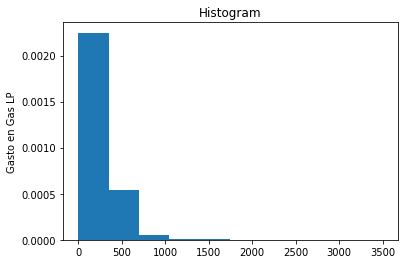

In [9]:
# plotting histogram in order to see
plt.hist(GasLP_df3.gasto_gaslp, normed = True, histtype='bar')

#plt.legend()
plt.ylabel('Gasto en Gas LP')
plt.title('Histogram')

plt.show()

In [10]:
GasLP_df3['cens'] = 0
GasLP_df3.loc[(GasLP_df3.lgasto_gaslp == 0), 'cens'] = -1
GasLP_df3

,folioviv,foliohog,ageb,est_dis,upm,factor,ubica_geo,entidad,cve_ent,Entidad,...,lp_gasnat,lp_gasnat_kg,gasto_carb,gasto_lena,gasto_perol,gasto_diesel,gasto_comb,gasto_otroscomb,acc_gasnat,cens
21,2801379302,1,149-5,451,0068810,581.0,280220001,Tamaulipas,28.0,TAMAULIPAS,...,5.414473,2.408761,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
58,2200516605,1,127-A,342,0053810,281.0,220140001,QuerÃ©taro,22.0,QUERÃTARO,...,5.094268,2.088556,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
59,2200516605,2,127-A,342,0053810,281.0,220140001,QuerÃ©taro,22.0,QUERÃTARO,...,5.094268,2.088556,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
60,2200516605,3,127-A,342,0053810,281.0,220140001,QuerÃ©taro,22.0,QUERÃTARO,...,5.094268,2.088556,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
61,2800704505,1,073-9,444,0068590,563.0,280090001,Tamaulipas,28.0,TAMAULIPAS,...,5.458271,2.452559,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70271,2400782706,1,135-9,375,0059190,459.0,240280001,San Luis PotosÃ­,24.0,SAN LUIS POTOSÃ,...,5.442227,2.436515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
70275,0100517201,1,167-4,001,0000530,236.0,010010001,Aguascalientes,1.0,AGUASCALIENTES,...,5.373145,2.367433,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
70277,0502466405,1,300-7,055,0012260,284.0,050300001,Coahuila de Zaragoza,5.0,COAHUILA DE ZARAGOZA,...,5.334800,2.329088,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
70295,0101464003,1,316-8,001,0001600,196.0,010010001,Aguascalientes,1.0,AGUASCALIENTES,...,5.466981,2.461269,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1


In [11]:
# Dfinimos variables
y = GasLP_df3.lgasto_gaslp
x = GasLP_df3[['ling_cor', 'ling_cor2', 'tot_integ', 'lp_gaslp', 'acc_gasnat']]

In [12]:
y

21       3.186077
58       3.555348
59       3.555348
60       3.555348
61       3.656012
           ...   
70271    0.000000
70275    0.000000
70277    0.000000
70295    0.000000
70307    0.000000
Name: lgasto_gaslp, Length: 14017, dtype: float32

In [13]:
# Variable de censura
cens = pd.Series(GasLP_df3.cens)
cens.value_counts()

 0    8713
-1    5304
Name: cens, dtype: int64

In [14]:
# Estimación del modelo Tobit

tr = TobitModel()
tr = tr.fit(x, y, cens, verbose = True)

         Current function value: 29377.512292
         Iterations: 26
         Function evaluations: 32
         Gradient evaluations: 32
      fun: 29377.51229181888
 hess_inv: array([[ 1.48541360e+01, -2.55997923e+00,  1.32637916e-01,
         5.28922884e-03, -9.94923919e-01,  2.47734242e-02,
        -3.73773071e-03],
       [-2.55997923e+00,  5.14141162e-01, -2.67937077e-02,
        -1.76430791e-03,  4.35034627e-02, -1.12281119e-04,
         8.38881892e-04],
       [ 1.32637916e-01, -2.67937077e-02,  1.40041844e-03,
         9.01221219e-05, -2.09809278e-03, -3.42407731e-05,
        -4.19519338e-05],
       [ 5.28922884e-03, -1.76430791e-03,  9.01221219e-05,
         3.28570490e-04,  6.86573353e-04,  2.88361267e-04,
         4.25291318e-05],
       [-9.94923919e-01,  4.35034627e-02, -2.09809278e-03,
         6.86573353e-04,  2.96344765e-01, -1.04671474e-02,
        -3.92008953e-04],
       [ 2.47734242e-02, -1.12281119e-04, -3.42407731e-05,
         2.88361267e-04, -1.04671474e-02,  

In [15]:
# Resultados
tr.intercept_, tr.coef_

(4.08074650429424,
 array([ 4.0807465 , -0.18037416,  0.33502266, -7.05119015, -0.01622044]))

In [16]:
tr.sigma_

4.054521931349934

In [17]:
# Adecuaciones a X:
x = sm.add_constant(x)

In [18]:
# OLS
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           lgasto_gaslp   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     154.7
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          1.76e-160
Time:                        08:47:56   Log-Likelihood:                -33613.
No. Observations:               14017   AIC:                         6.724e+04
Df Residuals:                   14011   BIC:                         6.728e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6519      2.559      1.036      0.3